Aluno: Luis Felipe dos Santos Ribeiro
Rio de janeiro, 28 de março de 2022

## Atividade II - Hands on Introduction to Machine Learning

# Primeira Etapa da atividade II - HIML (29/03/2022)

### Importação de pacotes e Leitura do dataset

In [1]:
import pandas as pd
import numpy as np 
import scipy.io as sio 
import matplotlib.pyplot as plt 
from os import getcwd
from os.path import join 

2. Leitura de datasets

In [2]:
mat_contents = sio.loadmat('data3SS2009.mat')
dataset = mat_contents['dataset']
n_samples, n_channels, n_cases = dataset.shape # N, Chno, Nc
y = mat_contents['labels'].reshape(n_cases)

Ch1 = pd.DataFrame(dataset[:,0,:])
Ch2 = pd.DataFrame(dataset[:,1,:])
Ch3 = pd.DataFrame(dataset[:,2,:])
Ch4 = pd.DataFrame(dataset[:,3,:])
Ch5 = pd.DataFrame(dataset[:,4,:])

In [3]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Modelo Autoregressivo

Modelo autoregressivo para determinação de coeficientes para aproximação da curva:

- y(t) = c_0 + x1 * t1 + ... xn*tn, com n = número de lags

In [4]:
from statsmodels.tsa.ar_model import AutoReg
Feat = []
lags = 30
for i in range(0,n_cases):
    ar_model_Ch1 = AutoReg(Ch2[i].values, lags = lags).fit()
    ar_model_Ch2 = AutoReg(Ch3[i].values, lags = lags).fit()
    ar_model_Ch3 = AutoReg(Ch4[i].values, lags = lags).fit()
    ar_model_Ch4 = AutoReg(Ch5[i].values, lags = lags).fit()
    ar_models = np.concatenate([ar_model_Ch1.params, ar_model_Ch2.params, ar_model_Ch3.params, ar_model_Ch4.params])
    Feat.append(ar_models)


### Vericando o número de componentes principais -> "Curva de Cotovelo"

Text(0.5, 0, 'n_components')

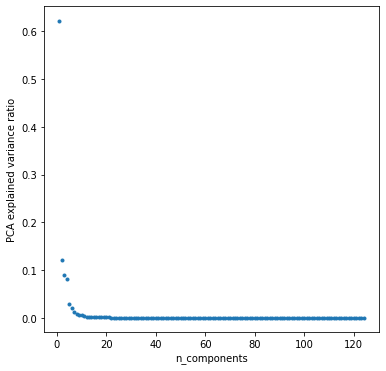

In [5]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

pca = PCA()
pca.fit(Feat)

# Plot the PCA spectrum
fig, ax0 = plt.subplots(nrows=1, sharex=True, figsize=(6, 6))

ax0.plot(
    np.arange(1, pca.n_components_ + 1), pca.explained_variance_ratio_, ".", linewidth=2
)
ax0.set_ylabel("PCA explained variance ratio")
ax0.set_xlabel("n_components")

    É possível visualizar que o número de componentes principais que apresentam garantem uma taxa variância do modelo é de 7 componentes ou mais.

### Softmax Regression 

1. Novos pacotes

In [6]:
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, accuracy_score 
from sklearn.model_selection import train_test_split
from sklearn import linear_model

2. Escalando modelo para valores no intervalo

In [7]:
pca = PCA(n_components=7)
Feat_reduced = pca.fit_transform(Feat)
Feat_reduced.shape

(850, 7)

In [8]:
minmax_scaler = preprocessing.MinMaxScaler()
Feat_scaler = minmax_scaler.fit_transform(Feat_reduced)
Y = mat_contents['labels'].reshape(n_cases)

3. Criando o modelo:

In [9]:
x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.4, random_state = 0)
modelo_softmax = linear_model.LogisticRegression(C = 1)
modelo_softmax.fit(x_train, y_train)

LogisticRegression(C=1)

4. Predições e aferições quanto a qualidade do modelo:

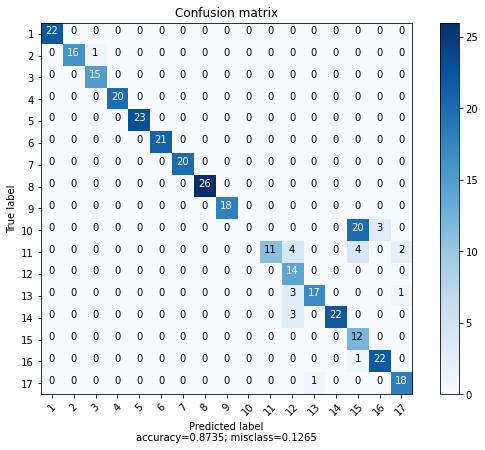

In [10]:
y_pred = modelo_softmax.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, target_names = range(1,18))

### Softmax usando outro método para escalar as variáveis:

0.961764705882353


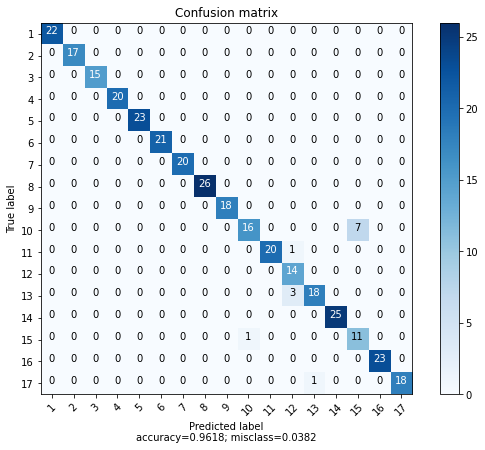

In [11]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df = sc.fit_transform(Feat_reduced)

x_train, x_test, y_train, y_test = train_test_split(df, Y, test_size = 0.4, random_state = 0 )
modelo_softmax_1 = linear_model.LogisticRegression(C=1)
modelo_softmax_1.fit(x_train, y_train)

y_pred = modelo_softmax_1.predict(x_test)
cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test, y_pred)
print(ac)
plot_confusion_matrix(cm, target_names = range(1,18))

### Verificação da acurácia do modelo softmax para diferentes número de componentes principais:

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-le

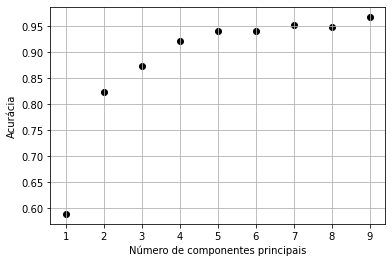

In [12]:
n_max_componentes = 10

for i in range(1,n_max_componentes):
    pca1 = PCA(n_components = i)
    pca1.fit(Feat)
    x_pca = pca1.transform(Feat)
    
    Y = mat_contents['labels'].reshape(n_cases)
    x_train, x_test, y_train, y_test = train_test_split(x_pca, Y, test_size = 0.3, random_state = 0)
    modelo_tot = linear_model.LogisticRegression()
    modelo_tot.fit(x_train, y_train)
    y_pred = modelo_tot.predict(x_test)
    ac = accuracy_score(y_test, y_pred)
    plt.figure(1)
    plt.xlabel('Número de componentes principais')
    plt.ylabel('Acurácia')
    plt.grid()
    plt.scatter(i, ac, color = 'black') 

    É possível observar que a partir de duas componentes principais o modelo já apresenta uma boa acurácia,
    ainda que se tenha uma taxa de variância conservada próximo a 90%

### Função para plot agradável da M. confusão:

# Segunda Etapa da atividade II - HIML (05/04/2022)

## Uso de SVM

### Releitura Dados:

In [13]:
from sklearn.svm import LinearSVC

    Os dados de entradas são o Feat_reduced (7 componentes principais)

### SVC

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


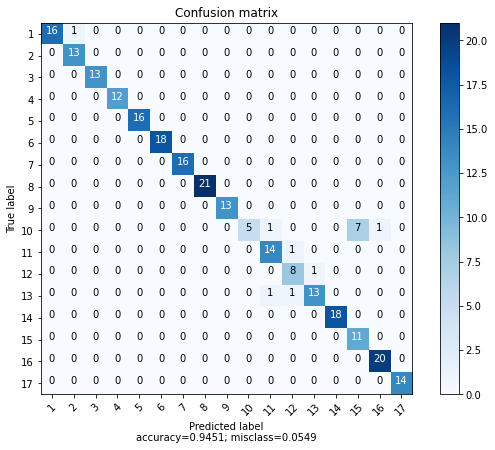

In [14]:
from sklearn.svm import LinearSVC

standart_scaler = preprocessing.StandardScaler()
Feat_scaler = standart_scaler.fit_transform(Feat_reduced)
Y = mat_contents['labels'].reshape(n_cases)

x_train, x_test, y_train, y_test = train_test_split(Feat_scaler, Y, test_size = 0.3, random_state = 0 )
modelo_svc = LinearSVC(C = 1, loss = 'hinge', random_state = 42)
modelo_svc.fit(x_train, y_train)

y_pred = modelo_svc.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(1,18))

## Validação Cruzada

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(modelo_svc, X = x_train, y = y_train, scoring = 'neg_mean_squared_error' , cv = 10)

svg_rmse_scores = np.sqrt(-scores)
print(svg_rmse_scores)

[1.21106014 1.12546287 1.08781126 0.78528127 1.36014705 1.38392711
 1.         1.07356526 1.47866179 0.86357554]


C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the numb

    É possível observar erros médios quadrados muito próximos a zero.

## Uso do KNN

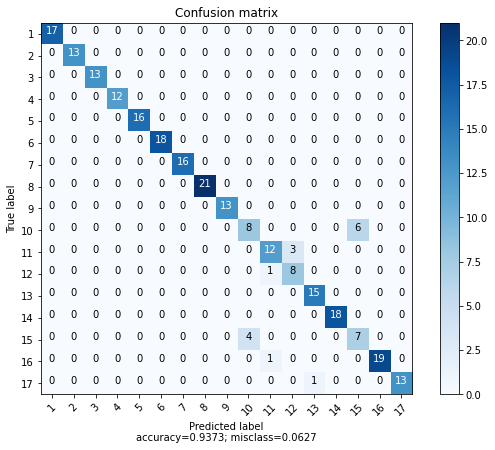

In [16]:
from sklearn.neighbors import KNeighborsClassifier


x_train, x_test, y_train, y_test = train_test_split(Feat_reduced, Y, test_size = 0.3, random_state = 0 )
modelo_knn = KNeighborsClassifier(n_neighbors = 1)
modelo_knn.fit(x_train, y_train)

y_pred = modelo_knn.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cm, target_names = range(1,18))

# Terceira Etapa da atividade II - HIML (12/04/2022)

Use randomized search with repeated cross-validation for hyperparameter
tuning. Use e.g. 

a) n_splits = 5, n_repeats = 50 [RepeatedKFold]

b) n_iter = 100, n_jobs = -1 (will use all your cores), cv = (object you created with
RepeatedKFold in 2.A), scoring = (choose a performance metric for classification
problems), [RandomizedSearchCV]

In [17]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import LinearSVC
import scipy.stats as stats
from sklearn.model_selection import RepeatedKFold

### 2. To optimize SVM params:

In [18]:
rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = 42)
rkf.split(x_train, y_train)

# Randomized Search
rand_parameters = [{'C':range(1,100), 'loss':['hinge', 'square_hinge']}]
modelo_svc = LinearSVC() 
random_search_svm = RandomizedSearchCV(modelo_svc, rand_parameters, verbose = 0, n_iter = 100,
                                       n_jobs = -1, cv = rkf, scoring = 'neg_mean_squared_error', random_state=42)
random_search_svm.fit(x_train, y_train)
BPSVC = random_search_svm.best_params_

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
12500 fits failed out of a total of 25000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
12500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py", line 257, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "C:\Users\luissantos\AppData\Lo

### 2. To optimize KNN params:

In [19]:
from sklearn.neighbors import KNeighborsClassifier

rkf = RepeatedKFold(n_splits = 5, n_repeats = 50, random_state = 42)
rkf.split(x_train, y_train)

# Randomized Search
rand_parameters = [{'n_neighbors':range(0,50), 'weights':['uniform', 'distance']}]
modelo_knn = KNeighborsClassifier() 
random_search_knn = RandomizedSearchCV(modelo_knn, rand_parameters, verbose = 0, n_iter = 100,
                                       n_jobs = -1, cv = rkf, scoring = 'neg_mean_squared_error', random_state=42)
random_search_knn.fit(x_train, y_train)
BP_knn = random_search_knn.best_params_

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
500 fits failed out of a total of 25000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neighbors\_classification.py", line 198, in fit
    return self._fit(X, y)
  File "C:\Users\luissantos\AppData\Local\Programs\Python\Python31

### 3. To optimize Softmax params:

In [20]:
from sklearn.linear_model import LogisticRegression
from scipy.stats import uniform

rkf = RepeatedKFold(n_splits = 5, n_repeats = 50)
rkf.split(x_train, y_train)

# Randomized Search
rand_parameters = [{'C':uniform(loc = 0, scale = 4), 'penalty':['l1', 'l2']}]
modelo_LRCV = LogisticRegression() 
random_search_LR = RandomizedSearchCV(modelo_LRCV, rand_parameters, verbose = 0, n_iter = 100,
                                       n_jobs = -1, cv = rkf, scoring = 'neg_mean_squared_error', random_state=42)
random_search_LR.fit(x_train, y_train)
BR_LR = random_search_LR.best_params_

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10750 fits failed out of a total of 25000.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10750 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\luissanto

### 4. Sintetização:

In [21]:
import pandas as pd 

result = pd.DataFrame(index = ['Paramentro 0','Paramentro 1'])
result['Knn_Best_Params'] = BP_knn 
result['Knn_Best_Params_Valor'] = BP_knn.values()
result['SVC_Best_Params'] = BPSVC
result['SVC_Best_Params_Valor'] = BPSVC.values()
result['L_Reg_Best_Params'] = BR_LR
result['L_Reg_Best_Params_Valor'] = BR_LR.values()
result.head()

,Knn_Best_Params,Knn_Best_Params_Valor,SVC_Best_Params,SVC_Best_Params_Valor,L_Reg_Best_Params,L_Reg_Best_Params_Valor
Paramentro 0,weights,distance,loss,hinge,C,3.947548
Paramentro 1,n_neighbors,5,C,9,penalty,l2


# Quarta Etapa da atividade II - HIML (26/04/2022)

Apply randomized search and cross-validation to obtain decision trees and random forest models

In [22]:
from scipy.stats import randint,uniform
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

#### 1. Simple Random Forest Model

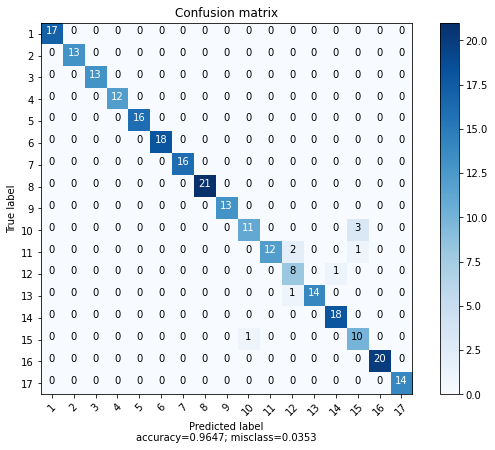

In [23]:
rfc = RandomForestClassifier(n_estimators = 500, n_jobs= -1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(1,18))

#### 2. Randomized Search of Decision Tree Model's parameters - REFAZER

C:\Users\luissantos\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_search.py:292: UserWarning: The total space of parameters 54 is smaller than n_iter=100. Running 54 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 54 candidates, totalling 270 fits


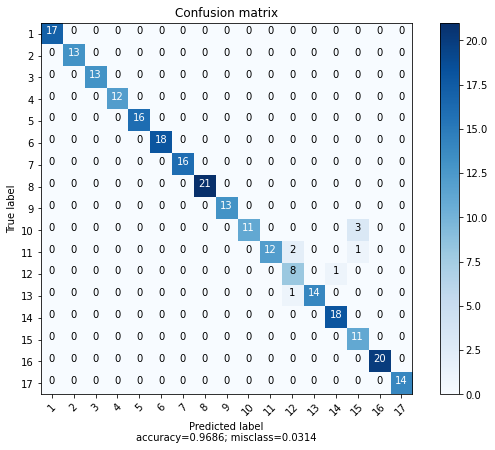

In [28]:
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 10, num = 5)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
random_grid = {'max_depth': max_depth, 'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            }

# Use the random grid to search for best hyperparameters
rf = DecisionTreeClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 5, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)
models = DecisionTreeClassifier(min_samples_split = 3, max_leaf_nodes = 10)
models.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(1,18))

#### 3. Randomized Search of Random Forest Model's parameters

In [25]:
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)]
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
            }


# Use the random grid to search for best hyperparameters
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000]},
                   random_state=42, verbose=2)

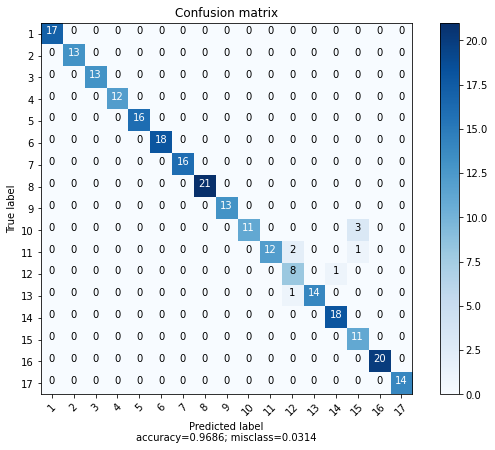

In [27]:
rfc = RandomForestClassifier(n_estimators = 400, min_samples_split=2, min_samples_leaf=1, n_jobs= -1)
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)

plot_confusion_matrix(confusion_matrix(y_test,y_pred), target_names= range(1,18))


# Quinta Etapa da atividade II - HIML (03/05/2022)

Using the 3-storey dataset from previuous activities, perform the following (having features constructed woth AR models and PCA)

-> Apply KMeans to 3 main components (PCA(n_features = 3)) and plot it.

-> Visualize your dataset using t-SNE.

-> Buidl a one-class classification SVM for nominal and failure modes.

### 1. PCA to reduce to 3 main components:

In [32]:
pca_clust = PCA(n_components=3)
pca_clust.fit(Feat)
Feat_clust = pca_clust.transform(Feat)

Text(0.5, 0, 'Third components')

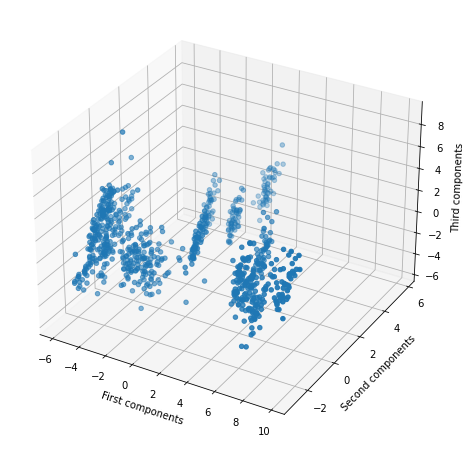

In [38]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(Feat_clust[:,0],Feat_clust[:,1],Feat_clust[:,2])
ax.set_xlabel('First components')
ax.set_ylabel('Second components')
ax.set_zlabel('Third components')

### 2. KMeans Clustering

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, 'Clustering results')

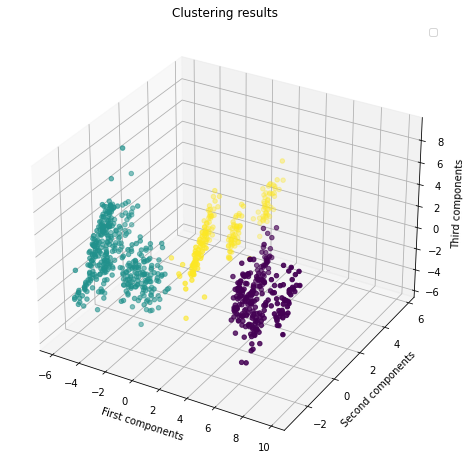

In [50]:
from sklearn.cluster import KMeans

Kmeans = KMeans(n_clusters = 3, random_state = 42).fit(Feat_clust)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(Feat_clust[:,0], Feat_clust[:,1], Feat_clust[:,2], c = Kmeans.labels_)
ax.legend()
ax.set_xlabel('First components')
ax.set_ylabel('Second components')
ax.set_zlabel('Third components')
ax.set_title('Clustering results')

### 3. t-SNE plotting 

In [66]:
from tSNE import * 
from matplotlib import pylab

Preprocessing the data using PCA...
Computing pairwise distances...
Computing P-values for point 0 of 850...
Computing P-values for point 500 of 850...
Mean value of sigma: 1.040593
Iteration 10: error is 13.217612
Iteration 20: error is 10.656683
Iteration 30: error is 9.672580
Iteration 40: error is 9.381519
Iteration 50: error is 9.290507
Iteration 60: error is 9.252636
Iteration 70: error is 9.214308
Iteration 80: error is 9.186138
Iteration 90: error is 9.162374
Iteration 100: error is 9.143033
Iteration 110: error is 0.486149
Iteration 120: error is 0.383883
Iteration 130: error is 0.337850
Iteration 140: error is 0.306593
Iteration 150: error is 0.285516
Iteration 160: error is 0.269503
Iteration 170: error is 0.257254
Iteration 180: error is 0.247727
Iteration 190: error is 0.240174
Iteration 200: error is 0.234070
Iteration 210: error is 0.229047
Iteration 220: error is 0.224918
Iteration 230: error is 0.221529
Iteration 240: error is 0.218631
Iteration 250: error is 0.216083


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Iteration 300: error is 0.207221


Text(0.5, 0.92, 'Clustering results')

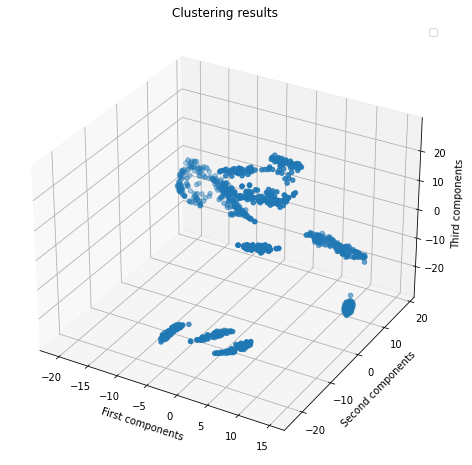

In [72]:
X = Feat_clust
labels = [1,2,3]
Y = tsne(X, 3, 7, 50.0)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(Y[:,0], Y[:,1], Y[:,2])
ax.legend()
ax.set_xlabel('First components')
ax.set_ylabel('Second components')
ax.set_zlabel('Third components')
ax.set_title('Clustering results')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, 'Clustering results')

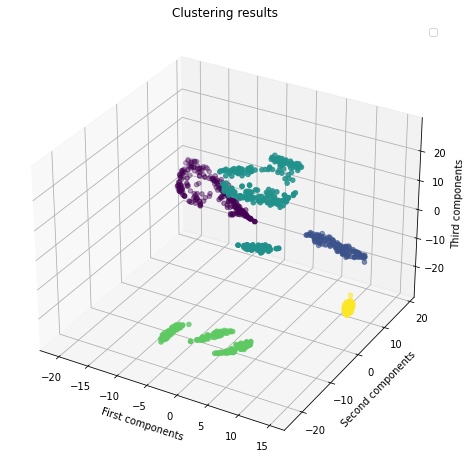

In [73]:
Kmeans = KMeans(n_clusters = 5, random_state = 42).fit(Y)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection = '3d')
ax.scatter(Y[:,0], Y[:,1], Y[:,2], c = Kmeans.labels_)
ax.legend()
ax.set_xlabel('First components')
ax.set_ylabel('Second components')
ax.set_zlabel('Third components')
ax.set_title('Clustering results')

### 4. OneClassSVM

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0.92, 'Clustering results')

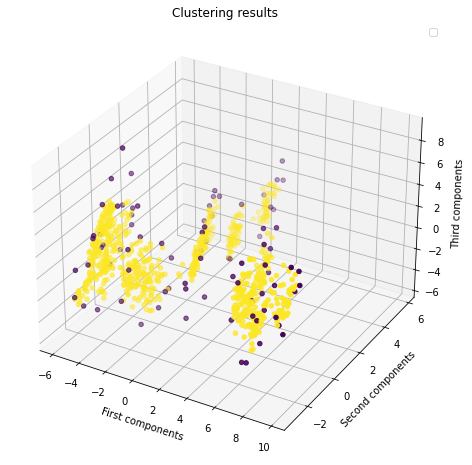

In [109]:
from sklearn.svm import OneClassSVM
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.ticker import FuncFormatter

X = Feat_clust
clf = OneClassSVM(nu = 0.1, gamma= 'auto').fit(X)

y_pred = clf.predict(X)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection = '3d')
sc = ax.scatter3D(X[:,0], X[:,1], X[:,2], c = y_pred)
ax.legend()
ax.set_xlabel('First components')
ax.set_ylabel('Second components')
ax.set_zlabel('Third components')
ax.set_title('Clustering results')

# Sexta Etapa da atividade II - HIML (10/04/2022)